In [ ]:
!pip install pytket

!pip install qiskit

!pip install pytket-qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.9/130.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer
from qiskit import execute

# create a circuit wrt tket
from qiskit.quantum_info.random import random_unitary
from pytket.extensions.qiskit import qiskit_to_tk, tk_to_qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_bloch_multivector
from qiskit.providers.aer import AerSimulator
from pytket.passes import EulerAngleReduction, KAKDecomposition

from typing import Optional, Union
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info.random import random_unitary
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library.generalized_gates.permutation import Permutation


from pytket.mapping import MappingManager
from pytket.utils import Graph
from pytket.architecture import Architecture
from pytket.circuit import Node
import networkx as nx
from pytket import Circuit, OpType
from pytket.circuit import display
from typing import List, Union, Tuple
from pytket.mapping import LexiLabellingMethod, LexiRouteRoutingMethod
from pytket.placement import Placement, LinePlacement, GraphPlacement

from pytket.passes import (
    SequencePass,
    CliffordSimp,
    DecomposeBoxes,
    KAKDecomposition,
    DefaultMappingPass,
    CXMappingPass,
    AASRouting,
    SynthesiseTket,
    RepeatPass
)

import pytket
from pytket.circuit import CustomGate
import cmath
from pytket.circuit import Circuit, CustomGateDef
from sympy import symbols

import re


In [ ]:
class QuantumVolume(QuantumCircuit):
    """A quantum volume model circuit.

    The model circuits are random instances of circuits used to measure
    the Quantum Volume metric, as introduced in [1].
    """

    def __init__(
        self,
        num_qubits: int,
        depth: Optional[int] = None,
        seed: Optional[Union[int, np.random.Generator]] = None,
        classical_permutation: bool = True,
    ) -> None:
        """Create quantum volume model circuit of size num_qubits x depth
        """
        # Initialize RNG
        if seed is None:
            rng_set = np.random.default_rng()
            seed = rng_set.integers(low=1, high=1000)
        if isinstance(seed, np.random.Generator):
            rng = seed
        else:
            rng = np.random.default_rng(seed)

        # Parameters
        depth = depth or num_qubits  # how many layers of SU(4)
        width = int(np.floor(num_qubits / 2))  # how many SU(4)s fit in each layer
        name = "quantum_volume_" + str([num_qubits, depth, seed]).replace(" ", "")

        # Generator random unitary seeds in advance.
        unitary_seeds = rng.integers(low=1, high=1000, size=[depth, width])
        indices_of_gates = np.empty((depth,width,2))
        self.indices_of_gates = indices_of_gates
        # For each layer, generate a permutation of qubits
        # Then generate and apply a Haar-random SU(4) to each pair
        circuit = QuantumCircuit(num_qubits, name=name)
        self.circuit = circuit

        #circuit.initialize(create_states_new(num_qubits),circuit.qubits)
        circuit.initialize('0'*num_qubits)
        perm_0 = list(range(num_qubits))
        for d in range(depth):
            perm = rng.permutation(perm_0)
            if not classical_permutation:
                layer_perm = Permutation(num_qubits, perm)
                circuit.compose(layer_perm, inplace=True)
            for w in range(width):
                seed_u = unitary_seeds[d][w]
                su4 = random_unitary(4, seed=seed_u).to_instruction()
                su4.label = "su4_" + str(seed_u)
                if classical_permutation:
                    physical_qubits = int(perm[2 * w]), int(perm[2 * w + 1])
                    indices_of_gates[d][w] = physical_qubits
                    circuit.compose(su4, [physical_qubits[0], physical_qubits[1]], inplace=True)
                else:
                    circuit.compose(su4, [2 * w, 2 * w + 1], inplace=True)

        super().__init__(*circuit.qregs, name=circuit.name)
        self.compose(circuit.to_instruction(), qubits=self.qubits, inplace=True)

In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=4ed951445bd523b1f04879d7c28f91d8d315bbb386d7edd8f197d2507f49912e
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


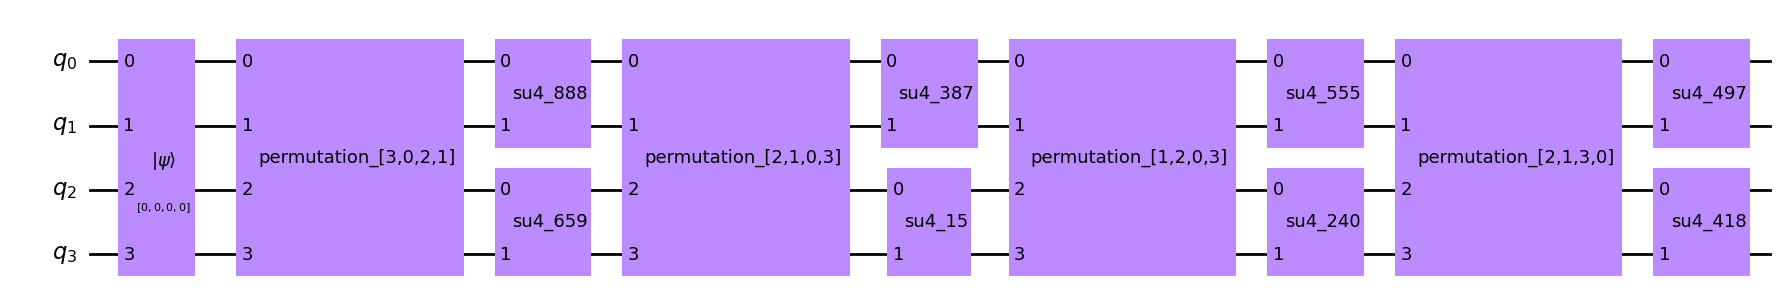

In [ ]:
n_qubits = 4

QV = QuantumVolume(n_qubits, classical_permutation = False)
initial_circuit = QV.circuit

initial_circuit.draw(output='mpl', scale = 1.0, fold = 30)

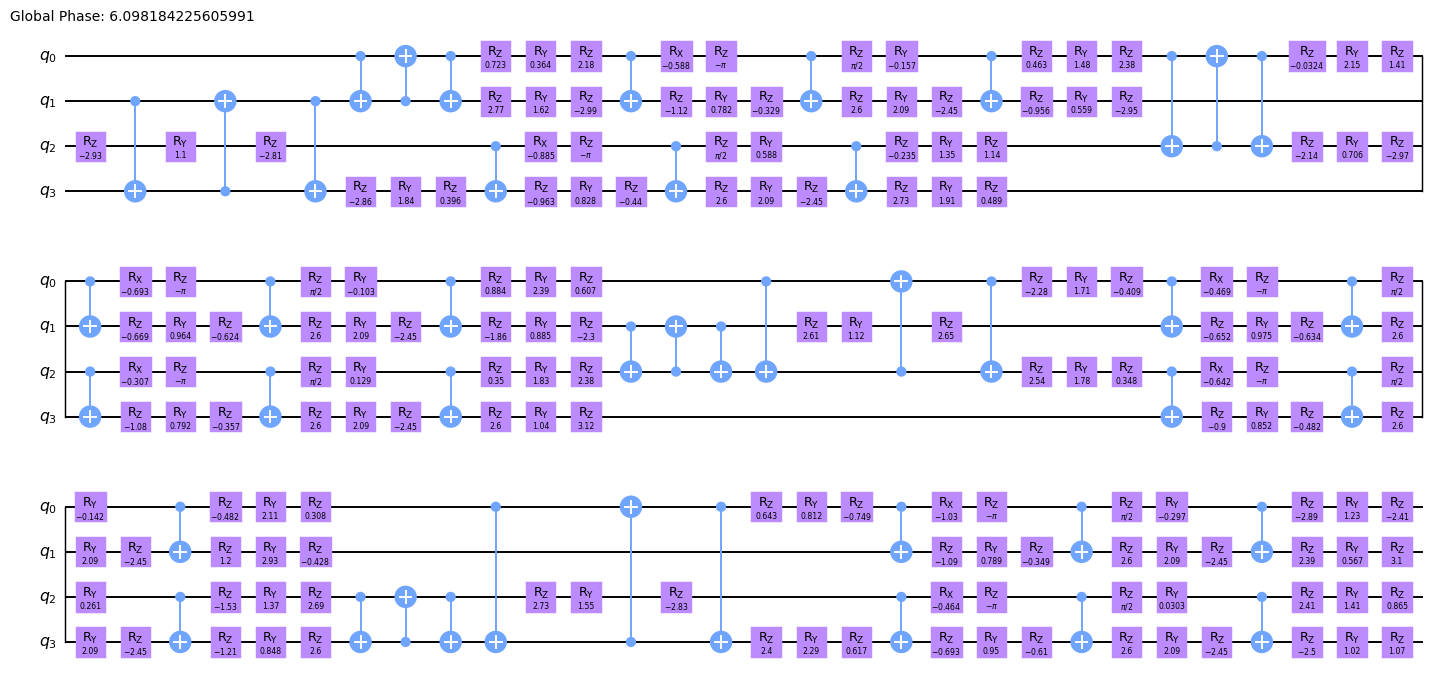

In [ ]:
from qiskit.circuit.library.standard_gates import PhaseGate
basis_gates = ['rx', 'ry', 'rz', 'cx']
decomposed_circuit = transpile(initial_circuit, basis_gates=basis_gates)
decomposed_circuit.draw(output='mpl', scale = 0.7, fold = 30)

In [ ]:
from pytket import Circuit, OpType
from pytket.circuit import display

n = [Node("n", i) for i in range(n_qubits)]
id_coupling_map = []
for j in range(n_qubits-1): id_coupling_map.append([n[j],n[j+1]])

id_architecture = Architecture(id_coupling_map)
mapping_manager = MappingManager(id_architecture)
lexi_label = LexiLabellingMethod()
lexi_route = LexiRouteRoutingMethod(10)


circ = qiskit_to_tk(decomposed_circuit)
#display.render_circuit_jupyter(circ)

#mapping_manager.route_circuit(circ, [lexi_label, lexi_route])

circ_qiskit = tk_to_qiskit(circ)

circ_qiskit.draw(output='mpl', scale = 0.6, fold = 40)
display.render_circuit_jupyter(circ)


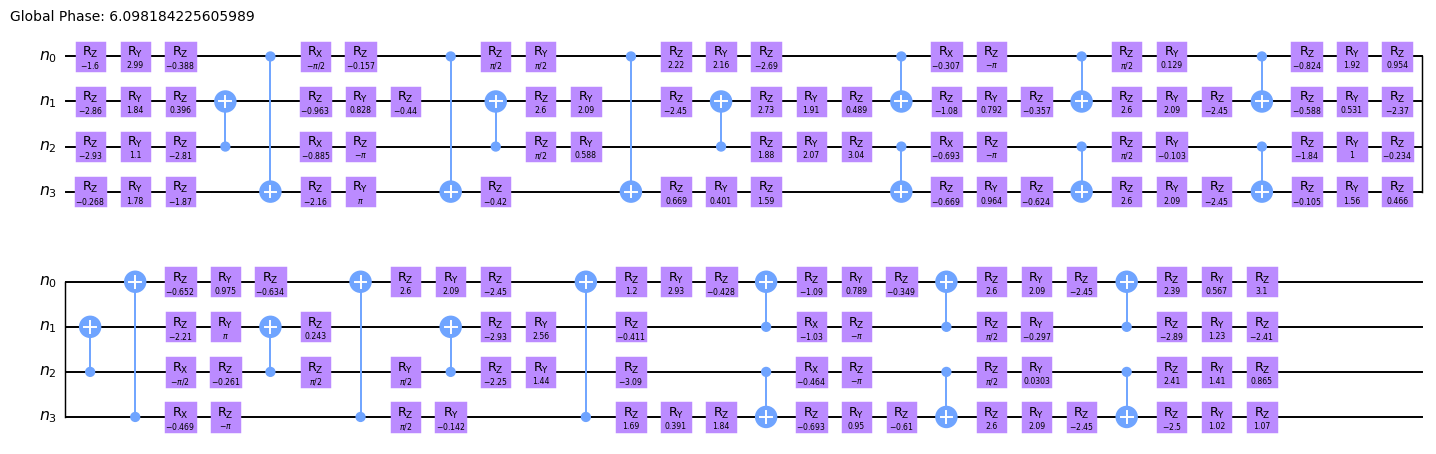

In [ ]:
DecomposeBoxes().apply(circ)
optimise = SequencePass([KAKDecomposition(),  CXMappingPass(id_architecture, Placement(id_architecture)), CliffordSimp(False), SynthesiseTket()])

optimise.apply(circ)

optimise.apply(circ)

optimise.apply(circ)

display.render_circuit_jupyter(circ)

circ_qiskit1 = tk_to_qiskit(circ)
circ_qiskit1 = transpile(circ_qiskit1, basis_gates=basis_gates)
circ_qiskit1.draw(output='mpl', scale = 0.7, fold = 30)


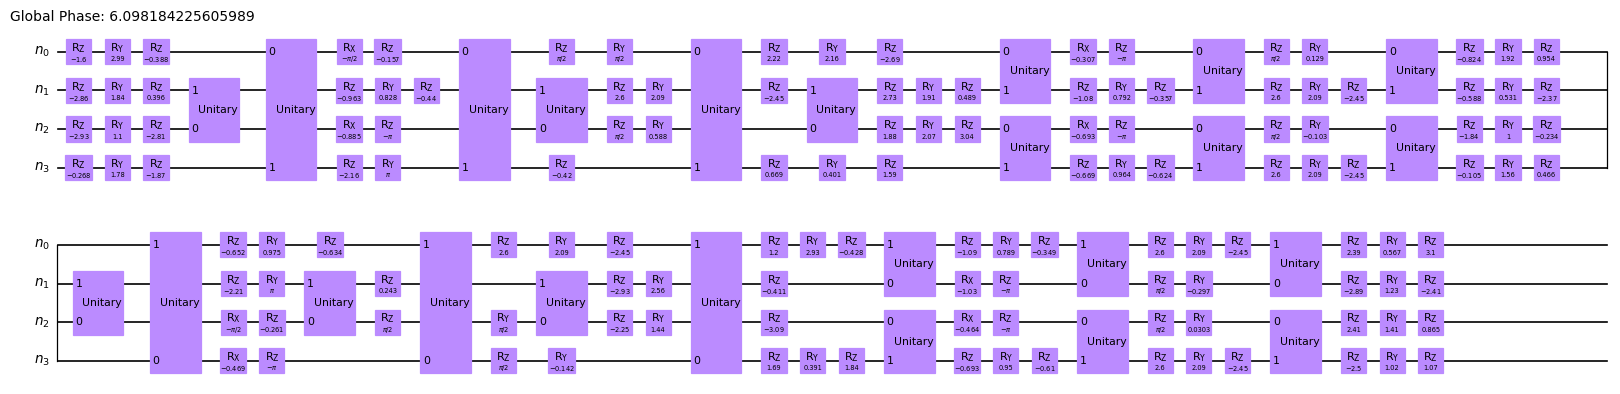

In [ ]:
new_circ = ReplaceCZ(1. - 0.01)(circ_qiskit1)
new_circ.draw(output='mpl', scale = 0.6, fold = 40)

In [ ]:

from qiskit.circuit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass

class ReplaceCZ(TransformationPass):
    """A transpiler pass to replace RYY and RZZ gates with RXX gates."""
    def __init__(self,angle):
        super().__init__()
        self.angle = angle

    def run(self, dag):
        """Run the pass."""

        # iterate over all operations
        for node in dag.op_nodes():

            # if we hit a RYY or RZZ gate replace it
            if node.op.name in ["cx"]:

                # calculate the replacement
                replacement = QuantumCircuit(2)

                replacement.unitary(np.array([[1, 0, 0, 0],
                                              [0, -1j*np.sin(self.angle/2.), 0, np.cos(self.angle/2.)],
                                              [0, 0, 1, 0],
                                              [0, np.cos(self.angle/2.), 0, -1j*np.sin(self.angle/2.)]]), [0, 1])

                # replace the node with our new decomposition
                dag.substitute_node_with_dag(node, circuit_to_dag(replacement))

        return dag

In [ ]:
def operation2(cases, num_qubits, depth, circ, cnot_prob):

  # Convert the circuit to a qiskit circuit
  old_circ = tk_to_qiskit(circ)

  #make a copy of old_circ
  new_circ = old_circ.copy()


  # Replace all CNOT gates in circuit with a custom gate CZ_err
  new_circ = ReplaceCZ(1. - cnot_prob)(old_circ)


  # Get the statevector of the new circuit
  noisy_amps = execute(new_circ, Aer.get_backend('statevector_simulator')).result().get_statevector()
  # Get the statevector of the old circuit
  noisless_amps = execute(old_circ, Aer.get_backend('statevector_simulator')).result().get_statevector()

  if cases == 'da':
    noisy_amps = noisy_amps*(1. - 1.8e-4)**(num_qubits*((num_qubits//2)+1)*(num_qubits//2))

  #Get the number of label cz_err gates in the new circuit
  noisy_num_cnots = 0.#old_circ.n_gates_of_type(OpType.CX)
  #get the number of CNOT gates in the old circuit
  num_cnots = 0.#old_circ.n_gates_of_type(OpType.CX)

  return num_cnots, np.abs(noisless_amps), noisy_num_cnots, np.abs(noisy_amps)#*(0.9999**total_disps_notcompiled )


In [ ]:
#TO FIND MAXIMUM ERROR
import numpy as np
from tqdm import tqdm

def isHeavy(cases, n_qubits, depth, cnot_prob, atom_loss, n_trials):

    ncnots_c, ncnots = [0]*n_trials,[0]*n_trials
    QV = True

    all_hp = np.empty([n_trials])
    #print(cnot_prob,'\n')
    #print((2*cnot_prob**2-1)*c + 2j*cnot_prob*(np.sqrt(1-cnot_prob**2)*d))

    #print('d,c', (2*cnot_prob**2-1)*d + 2j*cnot_prob*(np.sqrt(1-cnot_prob**2)*c)

    n = [Node("n", i) for i in range(n_qubits)]
    id_coupling_map = []
    for j in range(n_qubits-1): id_coupling_map.append([n[j],n[j+1]])

    id_architecture = Architecture(id_coupling_map)

    width = int(np.floor(n_qubits / 2))
    basis_gates = ['rx', 'ry', 'rz', 'cx']  # Basis gates for decomposition

    for i in range(n_trials):


        QV = QuantumVolume(n_qubits, depth=depth, classical_permutation = False)
        initial_circuit = QV.circuit

        #Use qiskit's transpile function to decompose the circuit into the desired basis
        decomposed_circuit = transpile(initial_circuit, basis_gates=basis_gates)
        circ = qiskit_to_tk(decomposed_circuit)
        init_amps = circ.get_statevector()

        DecomposeBoxes().apply(circ)
        optimise = SequencePass([KAKDecomposition(), CliffordSimp(False), SynthesiseTket()])
        optimise.apply(circ)

        if cases=='s':
          os = SequencePass([KAKDecomposition(),  CXMappingPass(id_architecture, Placement(id_architecture)), CliffordSimp(False), SynthesiseTket()])
          os.apply(circ)
          os.apply(circ)
          os.apply(circ)

        ncnots_c[i], famps_c, ncnots[i], famps = operation2(cases, n_qubits, depth, circ, cnot_prob) #case, num_qubits, depth, num_circuits

        probs_ascending_order_c = np.argsort(np.abs(famps_c)**2)
        probs_ascending_order = np.argsort(np.abs(famps)**2)

        hp = np.sum(np.array(np.abs(famps)**2)[probs_ascending_order_c[len(probs_ascending_order_c)//2:]])
        hp_c = np.sum(np.array(np.abs(famps_c)**2)[probs_ascending_order_c[len(probs_ascending_order_c)//2:]])

        all_hp[i] = hp

    cnots_c = np.mean(ncnots_c)
    cnots = np.mean(ncnots)

    case_hp = np.mean(all_hp)
    case_hp_std = np.std(all_hp)
    if case_hp < benchmark:
        QV = False

    all_qubits_hps = case_hp

    return QV, cnots_c, all_qubits_hps, case_hp_std


In [ ]:
nq_list = np.array([4,5,6,7,8,9,10])
hp_q = []
hp_q_std = []

for i in tqdm(nq_list):
  n_qubit = i
  depth = n_qubit#(n_qubit//2)*2
  n_trials = 50#min(999,2**max_qubits)
  benchmark = 2./3.
  atom_loss = 1.
  err_prob = np.arange(0.28,0.9999,0.0001)

  all_mer = []

  for i in range(1):
    left, right = 0, len(err_prob) - 1
    result = None
    while left <= right:

      mid = left + (right - left) // 2
      isQV = isHeavy('da', n_qubit, depth, err_prob[mid], atom_loss, n_trials)
       if not isQV[0]:
        result = err_prob[mid]
        left = mid + 1
      else:
        right = mid - 1
      print(result)

    all_mer.append(result)

  print(np.mean(all_mer), np.std(all_mer))
  hp_q.append(np.mean(all_mer))
  hp_q_std.append(np.std(all_mer))

  0%|          | 0/7 [00:00<?, ?it/s]

None
None
0.3698999999999901
0.3698999999999901
0.3698999999999901
0.3698999999999901
0.3698999999999901
0.3698999999999901
0.37129999999998997
0.3719999999999899
0.3719999999999899
0.3720999999999899


 14%|█▍        | 1/7 [05:22<32:14, 322.43s/it]

0.3721999999999899
0.3721999999999899 0.0
None
None
None
0.3248999999999951
0.3248999999999951
0.3248999999999951
0.33049999999999446
0.33329999999999416
0.334699999999994
0.3353999999999939
0.3356999999999939
0.3356999999999939


 29%|██▊       | 2/7 [12:03<30:43, 368.70s/it]

0.3356999999999939
0.3356999999999939 0.0
None
0.4598999999999802
0.5498999999999703
0.5948999999999653
0.5948999999999653
0.5948999999999653
0.5948999999999653
0.597699999999965
0.597699999999965
0.597699999999965
0.597699999999965


 43%|████▎     | 3/7 [22:41<32:47, 491.81s/it]

0.597699999999965
0.597699999999965 0.0
None
0.4598999999999802
0.5498999999999703
0.5948999999999653
0.5948999999999653
0.5948999999999653
0.6004999999999647
0.6032999999999644
0.6032999999999644
0.6032999999999644
0.6032999999999644


 57%|█████▋    | 4/7 [35:43<30:18, 606.22s/it]

0.6032999999999644
0.6032999999999644 0.0
0.6398999999999604
0.6398999999999604
0.6398999999999604
0.6848999999999554
0.707399999999953
0.7185999999999517
0.7185999999999517
0.7213999999999514
0.7227999999999513
0.7234999999999512
0.7237999999999511
0.7239999999999511


 71%|███████▏  | 5/7 [56:50<28:08, 844.34s/it]

0.7239999999999511
0.7239999999999511 0.0
0.6398999999999604
0.6398999999999604
0.6398999999999604
0.6848999999999554
0.707399999999953
0.7185999999999517
0.7241999999999511
0.7241999999999511
0.725599999999951
0.7262999999999509
0.7262999999999509


 86%|████████▌ | 6/7 [1:19:23<16:57, 1017.54s/it]

0.7262999999999509
0.7262999999999509 0.0
0.6398999999999604
0.6398999999999604
0.7298999999999505
0.7748999999999455
0.797399999999943
0.8085999999999418
0.8141999999999412
0.8169999999999409
0.8169999999999409
0.8176999999999408
0.8176999999999408
0.8177999999999408


100%|██████████| 7/7 [1:53:26<00:00, 972.30s/it] 

0.8177999999999408
0.8177999999999408 0.0


In [ ]:
print(hp_q, hp_q_std)

[0.3721999999999899, 0.3356999999999939, 0.597699999999965, 0.6032999999999644, 0.7239999999999511, 0.7262999999999509, 0.8177999999999408] [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
max_allowed_error = (3 - np.cos(1-hp_q)**2-2*np.cos(1-hp_q))/5.0
qubits = [4,5,6,7,8,9,10]

plt.plot(qubits, max_allowed_error, linestyle='--')
plt.xlabel('quantum volume')
plt.ylabel('Maximum allowed gate error')
plt.yscale('log')
plt.show()